In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

In [27]:
df = pd.read_csv("../data/engineered_interleaved_features_multi_stock_data.csv",index_col="Date")
df.drop(["Unnamed: 0"],axis="columns",inplace=True)
df.head()

,Close,Volume,Target,RAV,volatility,Buy_Sell_Strength,Weighted_Strength,Trend,Returns,Log_returns,...,volume_rank,return_rank,lag_market_return,market_std,zscore_vs_market,return_1,return_2,vol_3,close_z,market_mean_return
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-06,26.495502,174826400,1,2.508224e+08,1.046603,0.266668,-0.162635,-0.007055,-0.008421,8.064542,...,0.75,0.50,NaN,0.006663,-0.131420,NaN,NaN,NaN,NaN,-0.007546
2015-02-06,36.218147,34616600,0,5.097210e+07,2.133879,0.406248,-0.063670,0.022419,-0.000943,10.087206,...,0.25,1.00,-0.007546,0.006663,0.991042,-0.008421,NaN,NaN,NaN,-0.007546
2015-02-06,0.489517,210524000,0,2.155857e+08,0.010619,0.225000,-0.268543,0.023777,-0.004392,-0.689525,...,1.00,0.75,-0.007546,0.006663,0.473265,-0.000943,-0.008421,1.063700,NaN,-0.007546
2015-02-06,14.490667,48658500,1,5.486293e+07,0.608197,0.124639,-0.332912,0.016009,-0.016426,5.386730,...,0.50,0.25,-0.007546,0.006663,-1.332886,-0.004392,-0.000943,0.917565,NaN,-0.007546
2015-02-09,26.671505,155559200,1,2.247958e+08,1.096023,0.914897,0.287110,0.010177,0.006643,8.139063,...,0.75,1.00,NaN,0.003672,1.466347,-0.016426,-0.004392,0.571613,NaN,0.001259


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10764 entries, 2015-02-06 to 2025-10-17
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Close               10764 non-null  float64
 1   Volume              10764 non-null  int64  
 2   Target              10764 non-null  int64  
 3   RAV                 10764 non-null  float64
 4   volatility          10764 non-null  float64
 5   Buy_Sell_Strength   10764 non-null  float64
 6   Weighted_Strength   10764 non-null  float64
 7   Trend               10764 non-null  float64
 8   Returns             10764 non-null  float64
 9   Log_returns         10764 non-null  float64
 10  AAPL                10764 non-null  bool   
 11  MSFT                10764 non-null  bool   
 12  NVDA                10764 non-null  bool   
 13  TSLA                10764 non-null  bool   
 14  market_return       10764 non-null  float64
 15  rel_return          10764 non-null  float64


In [37]:
tf.random.set_seed(7)

In [46]:
X = df.drop(['Target','lag_market_return','close_z', 'vol_3', 'return_2', 'return_1',"market_mean_return"], axis="columns")
y = np.array(df['Target'])
print(len(X), len(y))

10764 10764


In [47]:
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.85)
X_train, X_val, X_test = X[0:train_size], X[train_size:val_size], X[val_size:len(X)]
y_train, y_val, y_test = y[0:train_size], y[train_size:val_size], y[val_size:len(y)]
print(len(X_train), len(X_test), len(X_val), len(y_train), len(y_test), len(y_val))

7534 1615 1615 7534 1615 1615


In [48]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
X_val_scaled  = scaler.transform(X_val)

In [49]:
def creat_sequence(X, y, time_stamp=5):
    Xs, ys = [], []
    for i in range(len(X) - time_stamp):
        Xs.append(X[i:(i + time_stamp)])
        ys.append(y[i + time_stamp])
    return np.array(Xs), np.array(ys)

In [58]:
time_stamp = 20
features = len(X.columns)
X_train_seq, y_train_seq = creat_sequence(X_train_scaled, y_train, time_stamp)
X_val_seq, y_val_seq = creat_sequence(X_val_scaled, y_val, time_stamp)
X_test_seq, y_test_seq = creat_sequence(X_test_scaled, y_test, time_stamp)

print(X_train_seq.shape, y_train_seq.shape)
print(X_val_seq.shape, y_val_seq.shape)
print(X_test_seq.shape, y_test_seq.shape)

(7514, 20, 21) (7514,)
(1595, 20, 21) (1595,)
(1595, 20, 21) (1595,)


In [59]:
for i in range(5):
    print(f"sequence {i}")
    print("X window indices:", list(range(i, i + time_stamp)))
    print("Target index:", i + time_stamp)
    print("y target:", y[i + time_stamp])
    print("-" * 130)

sequence 0
X window indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Target index: 20
y target: 1
----------------------------------------------------------------------------------------------------------------------------------
sequence 1
X window indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Target index: 21
y target: 1
----------------------------------------------------------------------------------------------------------------------------------
sequence 2
X window indices: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Target index: 22
y target: 1
----------------------------------------------------------------------------------------------------------------------------------
sequence 3
X window indices: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Target index: 23
y target: 1
-------------------------------------------------------------------------------------

In [163]:
# Define the model
model = Sequential()


model.add(LSTM(units=64, input_shape=(time_stamp, features), return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units=32, return_sequences=False))
# model.add(Dropout(0.1))

# model.add(LSTM(units=16, return_sequences=False))
# model.add(Dropout(0.2))

model.add(Dense(32, activation="tanh"))
# Add a Dense output layer
model.add(Dense(1, activation="sigmoid"))

# Compile the model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.005,  clipnorm=1.0)
model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,        
    restore_best_weights=True
)

model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    batch_size=64,
    epochs=50,
    # callbacks=[early_stop]
)
model.summary()
print(model.loss, model.optimizer)

Epoch 1/50


C:\Users\dalu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5268 - loss: 0.6941 - val_accuracy: 0.5191 - val_loss: 0.6926
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5258 - loss: 0.6915 - val_accuracy: 0.5191 - val_loss: 0.6960
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5283 - loss: 0.6917 - val_accuracy: 0.5191 - val_loss: 0.6931
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5325 - loss: 0.6915 - val_accuracy: 0.5191 - val_loss: 0.6928
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5325 - loss: 0.6914 - val_accuracy: 0.5191 - val_loss: 0.6930
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5325 - loss: 0.6915 - val_accuracy: 0.5191 - val_loss: 0.6924
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5325 - loss: 0.6913 - val_accuracy: 0.5191 - val_loss: 0.6926
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5325 - loss: 0.6913 - val_accuracy: 0.519

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_98 (LSTM)                  │ (None, 20, 64)         │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_99 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,565 (416.27 KB)

 Trainable params: 35,521 (138.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 71,044 (277.52 KB)

binary_crossentropy <keras.src.optimizers.adam.Adam object at 0x0000024244F277A0>


In [235]:
# Define the model
model = Sequential()


model.add(LSTM(units=128, input_shape=(time_stamp, features), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=False))
# model.add(Dropout(0.1))

# model.add(LSTM(units=32, return_sequences=False))
# model.add(Dropout(0.2))

model.add(Dense(32, activation="tanh"))
# Add a Dense output layer
model.add(Dense(1, activation="sigmoid"))

# Compile the model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.005,  clipnorm=1.0)
model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,        
    restore_best_weights=True
)

model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    batch_size=64,
    epochs=30,
    # callbacks=[early_stop]
)
model.summary()
print(model.loss, model.optimizer)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.5301 - loss: 0.6943 - val_accuracy: 0.5191 - val_loss: 0.6942
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.5306 - loss: 0.6916 - val_accuracy: 0.5191 - val_loss: 0.6926
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5295 - loss: 0.6913 - val_accuracy: 0.5191 - val_loss: 0.6926
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.5325 - loss: 0.6914 - val_accuracy: 0.5191 - val_loss: 0.6925
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.5325 - loss: 0.6917 - val_accuracy: 0.5191 - val_loss: 0.6929
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.5325 - loss: 0.6916 - val_accuracy: 0.5191 - val_loss: 0.6927
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.5306 - loss: 0.6917 - val_accuracy: 0.5191 - val_loss: 0.6925
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.5326 - loss: 0.6914 - val_acc

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_164 (LSTM)                 │ (None, 20, 128)        │        76,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_165 (LSTM)                 │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 384,965 (1.47 MB)

 Trainable params: 128,321 (501.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 256,644 (1002.52 KB)

binary_crossentropy <keras.src.optimizers.adam.Adam object at 0x000002424E9E3C50>


In [236]:
model.evaluate(X_test_seq,y_test_seq)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5191 - loss: 0.7062


[0.7061724066734314, 0.5191222429275513]

In [237]:
y_proba = model.predict(X_test_seq)  
y_pred = (y_proba.ravel() >= 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_seq, y_pred))
print(confusion_matrix(y_test_seq, y_pred))
print(y_proba[:5])
print("LSTM",np.bincount(y_pred))

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

           0       0.48      0.53      0.50       735
           1       0.56      0.51      0.53       860

    accuracy                           0.52      1595
   macro avg       0.52      0.52      0.52      1595
weighted avg       0.52      0.52      0.52      1595

[[390 345]
 [422 438]]
[[0.58436704]
 [0.56382674]
 [0.51411784]
 [0.6737244 ]
 [0.6981603 ]]
LSTM [812 783]


In [243]:
import joblib

joblib.dump(model,'../models/v3_lstm_stock_pediction.joblib')

['../models/v3_lstm_stock_pediction.joblib']

In [110]:
model.evaluate(X_test_seq,y_test_seq)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5354 - loss: 0.7794


[0.7794459462165833, 0.535423219203949]

In [111]:
y_proba = model.predict(X_test_seq)  
y_pred = (y_proba.ravel() >= 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_seq, y_pred))
print(confusion_matrix(y_test_seq, y_pred))
print(y_proba[:5])
print("LSTM",np.bincount(y_pred))

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

           0       0.50      0.53      0.51       735
           1       0.57      0.54      0.56       860

    accuracy                           0.54      1595
   macro avg       0.53      0.53      0.53      1595
weighted avg       0.54      0.54      0.54      1595

[[388 347]
 [394 466]]
[[0.26281497]
 [0.4501934 ]
 [0.57042277]
 [0.6980202 ]
 [0.83769405]]
LSTM [782 813]


In [35]:
scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
print(scaled_df.isna().sum().sort_values(ascending=False).head())

Close               0
Volume              0
zscore_vs_market    0
market_std          0
return_rank         0
dtype: int64


In [36]:
print(X_train.nunique())

Close                 7358
Volume                7503
RAV                   7528
volatility            7533
Buy_Sell_Strength     7442
Weighted_Strength     7530
Trend                 7534
Returns               7508
Log_returns           7531
AAPL                     2
MSFT                     2
NVDA                     2
TSLA                     2
market_return         1884
rel_return            7533
mean_return_others    1884
divergence            7533
volume_rank              4
return_rank              5
market_std            1884
zscore_vs_market      7533
market_mean_return    1884
dtype: int64


In [37]:
print(np.isnan(X_train_scaled).sum())
print(np.isinf(X_train_scaled).sum())
print(X_train_scaled.min(), X_train_scaled.max())

0
0
0.0 1.0000000000000002


In [38]:
mask = np.isnan(y_train)
print(mask.sum())

0


In [39]:
print(np.isnan(X_train_seq).sum(), np.isinf(X_train_seq).sum())
print(X_train_seq.std(), X_train_seq.mean())

0 0
0.3140208522539836 0.3276449305495515


In [182]:
min(norms), max(norms)

(nan, nan)

In [128]:
import numpy as np
weights = model.trainable_weights
norms = [np.linalg.norm(w.numpy()) for w in weights]
min(norms), max(norms)

(nan, nan)

In [129]:
print(model.optimizer.learning_rate)

<Variable path=adamw/learning_rate, shape=(), dtype=float32, value=0.0010000000474974513>


In [218]:
X_2_features = ['market_return', 'Weighted_Strength', 'mean_return_others','TSLA', 'AAPL', 'NVDA', 'MSFT']
X_2 = X[X_2_features]

train_size = int(len(X_2) * 0.70)
val_size = int(len(X_2) * 0.85)
X_train, X_val, X_test = X_2[0:train_size], X_2[train_size:val_size], X_2[val_size:len(X_2)]
y_train, y_val, y_test = y[0:train_size], y[train_size:val_size], y[val_size:len(y)]
print(len(X_train), len(X_test), len(X_val), len(y_train), len(y_test), len(y_val))

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
X_val_scaled  = scaler.transform(X_val)

time_stamp = 20
features = len(X_2.columns)
X_train_seq, y_train_seq = creat_sequence(X_train_scaled, y_train, time_stamp)
X_val_seq, y_val_seq = creat_sequence(X_val_scaled, y_val, time_stamp)
X_test_seq, y_test_seq = creat_sequence(X_test_scaled, y_test, time_stamp)
print(X_train_seq.shape, y_train_seq.shape)

model = Sequential()

model.add(LSTM(units=128, input_shape=(time_stamp, features), return_sequences=True))
model.add(Dropout(0.2))
          
model.add(LSTM(units=64, return_sequences=True)) 
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
# model.add(Dropout(0.2))

model.add(Dense(64, activation="tanh"))
model.add(Dense(1, activation="sigmoid"))

from tensorflow.keras.optimizers import AdamW
optimizer = AdamW(learning_rate=0.005)

model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,        
    restore_best_weights=True
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,        # reduce by half
    patience=3,         # after 3 bad epochs
    min_lr=1e-6         # never go below this
)


model.fit(
    X_train_seq,y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    batch_size=16,
    epochs=50,
    # callbacks=[early_stop]
)
y_proba = model.predict(X_test_seq)  
y_pred = (y_proba.ravel() >= 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_seq, y_pred))
print(confusion_matrix(y_test_seq, y_pred))

7534 1615 1615 7534 1615 1615
(7514, 20, 7) (7514,)
Epoch 1/50


C:\Users\dalu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


470/470 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.5220 - loss: 0.6926 - val_accuracy: 0.5191 - val_loss: 0.6926
Epoch 2/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.5325 - loss: 0.6915 - val_accuracy: 0.5191 - val_loss: 0.6927
Epoch 3/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.5325 - loss: 0.6913 - val_accuracy: 0.5191 - val_loss: 0.6925
Epoch 4/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.5315 - loss: 0.6913 - val_accuracy: 0.5191 - val_loss: 0.6924
Epoch 5/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.5314 - loss: 0.6913 - val_accuracy: 0.5191 - val_loss: 0.6924
Epoch 6/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.5325 - loss: 0.6912 - val_accuracy: 0.5191 - val_loss: 0.6924
Epoch 7/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.5314 - loss: 0.6912 - val_accuracy: 0.5191 - val_loss: 0.6924
Epoch 8/50
470/470 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.5325 - loss: 0.6913 - val_accurac

KeyboardInterrupt: 

In [79]:
model.evaluate(X_test_seq,y_test_seq)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5392 - loss: 0.6911


[0.6910983324050903, 0.5391849279403687]

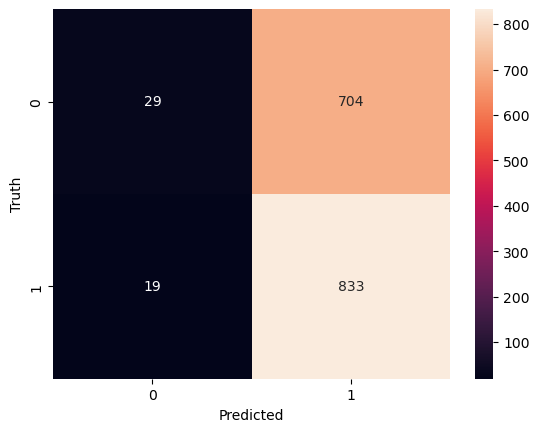

In [198]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test_seq, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [125]:
np.unique(y_train_seq, return_counts=True), y_train_seq.dtype

((array([0, 1], dtype=int64), array([3513, 4001], dtype=int64)),
 dtype('int64'))

In [138]:
np.unique(y_train)

array([0, 1], dtype=int64)